# Testing and Comparing Models

How do we know if our model is accurate? How can we determine which variables we should model and the relative costs of including those variables? This notebook will discuss tools for assessing and comparing models. This notebook is intended to accompany a lecture and is thus not as verbose as other notebooks.

In [12]:
import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

# some settings for making plots
import seaborn as sns
import matplotlib.pyplot as plt
from cycler import cycler
plt.style.use("ggplot")
palette = ["#00B0F6", "#F8766D", "#00BF7D", "#A3A500", "#E76BF3"]
plt.rc('axes', prop_cycle=(cycler('color', palette)))

Start by loading the data and taking a look at the distribution of data, which predictors do we think are going to be useful? Is it always obvious how useful a predictor will be? Should we discount a predictor just because it doesn't "look" correlated?

In [13]:
# load some data
df = pd.read_csv("dummy_data.csv")
df.describe()

,Var1,Var2,Var3,Var4,Target
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.470181,0.995663,1.552804,0.491149,14.380958
std,0.297489,0.586223,0.880279,0.293452,18.702951
min,0.005522,0.013904,0.015185,0.014393,-16.645584
25%,0.193201,0.484009,0.830640,0.249615,-1.382180
50%,0.464142,1.011250,1.687665,0.509718,11.255841
75%,0.730203,1.532367,2.257101,0.735778,26.777018
max,0.986887,1.971301,2.970162,0.990505,61.781654


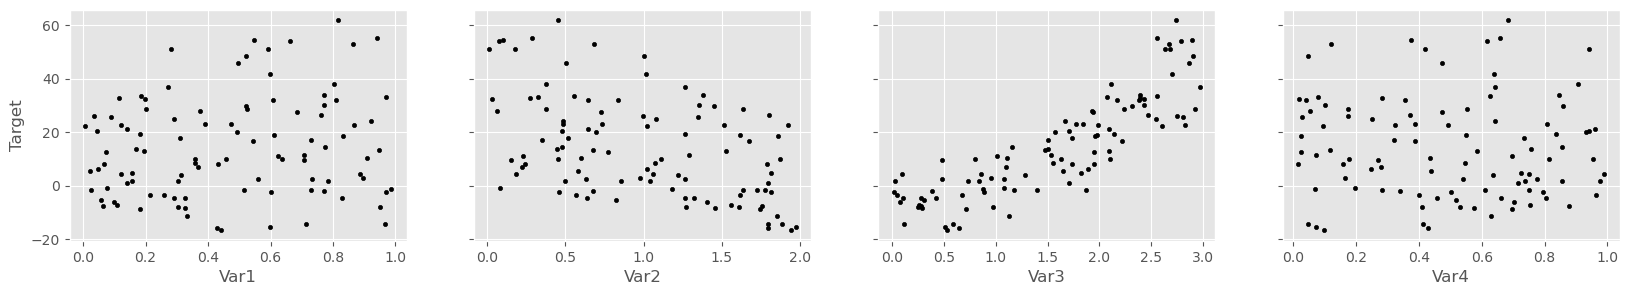

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 3), sharey=True)

for i in range(4):
    ax[i].set_xlabel(df.columns[i])
    ax[i].scatter(df.iloc[:,i], df.Target, color='k', marker='.')
ax[0].set_ylabel("Target")
plt.show()

Let's say we are trying to build a predictive model to help us find an even higher value than we have observed thus far. To assess this we should remove the to XX% of our dataset and see if we can use lower data to predict higher data. 

In [15]:
# let's grab the top 15% of data to serve as a test set
test_df = df.sort_values("Target").iloc[-10:]
train_df = df.sort_values("Target").iloc[:90]

`Var3` and `Var2` seem to have a strong relationships with or `Target`, so we can start with that for our model and see how it performs.

In [16]:
model = smf.ols('Target ~ Var3 + Var2', data=train_df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Target   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     256.9
Date:                Fri, 05 Jul 2024   Prob (F-statistic):           3.12e-37
Time:                        17:07:32   Log-Likelihood:                -281.38
No. Observations:                  90   AIC:                             568.8
Df Residuals:                      87   BIC:                             576.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6211      1.613     -0.385      0.7

Our model seems to perform ok on the training data, but let's see how well it does on the testing data that we excluded from training.

In [17]:
train_pred = model.get_prediction(train_df) 
test_pred = model.get_prediction(test_df)

print("Train MAE: ", mean_absolute_error(train_df.Target.values, train_pred.predicted))
print("Test MAE: ", mean_absolute_error(test_df.Target.values, test_pred.predicted))

Train MAE:  4.2865040080541625
Test MAE:  15.809610751143103


It would appear that we are greatly overfitting our data! Our test set error is approximately 20% of the span of the target data range! This is model is unlikely to help us find new, better material that exceed our current data range!

While we could continue to iterate with new models, we start to run into an issue of fitting the testing data. As we continue to update our model to improve test set performance we are in a sense optimizing for the test set and thus we no longer have an objective measure of model performance on unseen data! One solution would be to create a third split that we can use for validation tests, but then we will be further limiting our training data and thus likely our model performance. Additionally, our performance on the validation set might depend on the split itself, which may lead us astray in terms of optimal parameters.

A better approach to model validation is to split our training data into K groups and then iteratively fit K-1 groups and predict on the last. This will allow us to use more our training data and give us an idea of the amount of variability in predictive performance as a function of data splitting. It is still a good idea to hold out a test set as a final predictive check as that will be your objective performance measure.

Mean Train MSE 30.090180138724918
Mean Validation MSE 37.31946936399129


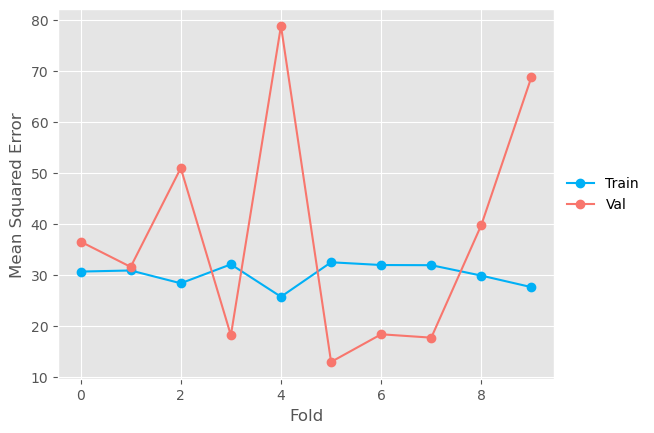

In [18]:
train_mse_scores = []
val_mse_scores = []

kf = KFold(n_splits=10, shuffle=False)

for split in kf.split(train_df):
    train_fold, val_fold = split
    
    train_fold_df = train_df.iloc[train_fold]
    val_fold_df = train_df.iloc[val_fold]

    model = smf.ols('Target ~ Var3+Var2', data=train_fold_df).fit()

    train_mse = mean_squared_error(train_fold_df.Target, model.predict(train_fold_df))
    train_mse_scores.append(train_mse)
    
    val_mse = mean_squared_error(val_fold_df.Target, model.predict(val_fold_df))
    val_mse_scores.append(val_mse)

print("Mean Train MSE",np.mean(train_mse_scores))
print("Mean Validation MSE", np.mean(val_mse_scores))

plt.plot(train_mse_scores, marker='o', label='Train')
plt.plot(val_mse_scores, marker='o', label='Val')
plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Fold')
plt.ylabel('Mean Squared Error')
plt.show()

In the above we iterated through 10 data splits fitting and testing the data against the remaining validation set. We see that there is quite a bit of variability in the validation outcome, but on average we get an MSE score of about 37. We could manually update the model and try again, but it would be more efficint to try different models programmatically.

In the code below, we try three models with different exponential terms on the `Var3` predictor. We then plot the average validation and training MSE scores as a function of the exponetial term. Through this simple look we see how we can quickly iterate through and compare different models.

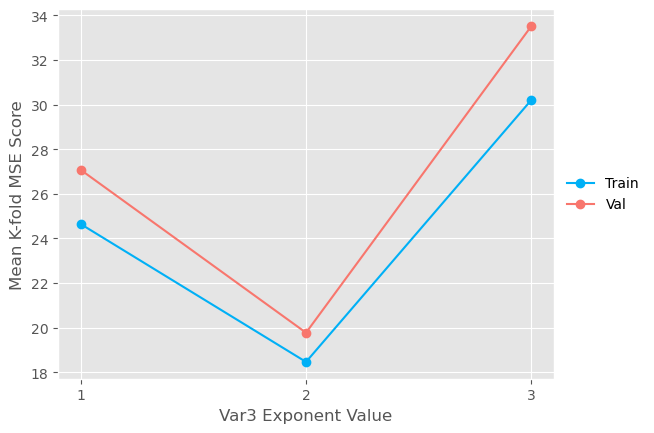

In [19]:
train_scores = []
val_scores = []

for i in [1,2,3]:

    def fit_ols(df):
        def expon(x):
            return x**i
        model = smf.ols('Target ~ expon(Var3)+Var2+Var1', data=df).fit()
        return model

    train_mse_scores = []
    val_mse_scores = []

    kf = KFold(n_splits=10, shuffle=True)

    for split in kf.split(train_df):
        train_fold, val_fold = split
        
        train_fold_df = train_df.iloc[train_fold]
        val_fold_df = train_df.iloc[val_fold]

        model = fit_ols(train_fold_df)

        train_mse = mean_squared_error(train_fold_df.Target, model.predict(train_fold_df))
        train_mse_scores.append(train_mse)
        
        val_mse = mean_squared_error(val_fold_df.Target, model.predict(val_fold_df))
        val_mse_scores.append(val_mse)

    train_scores.append(np.mean(train_mse_scores))
    val_scores.append(np.mean(val_mse_scores))

# print("Mean Train MSE",np.mean(train_mse_scores))
# print("Mean Val MSE", np.mean(val_mse_scores))

plt.plot(train_scores, marker='o', label='Train')
plt.plot(val_scores, marker='o', label='Val')
plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks([0, 1, 2], [1,2,3])
plt.xlabel("Var3 Exponent Value")
plt.ylabel("Mean K-fold MSE Score")
plt.show()

From these results it becomes clear that we should exponentiate `Var3` and also clear how we might proceed with finding new models programmatically.

# Now you try it!
- Use the dataset from before and compare the performance of a linear regression model using K-Fold vs train test split

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

# Write the code below